# Importamos las Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Funciones

In [2]:
def parse_money(s):
    """
    Convierte strings de dinero tipo:
    '3.952.17', '2.469.49', '-11.95', etc.
    a float: 3952.17, 2469.49, -11.95
    """
    if pd.isna(s):
        return np.nan
    
    s = str(s).strip()
    # Nos quedamos solo con dígitos, signo, puntos y comas
    s = re.sub(r"[^0-9\-,\.]", "", s)
    
    # Si hay coma o punto, tomamos el último como separador decimal
    if "," in s or "." in s:
        last_pos = max(s.rfind(","), s.rfind("."))
        int_part = re.sub(r"[^\d-]", "", s[:last_pos])
        dec_part = re.sub(r"[^\d]", "", s[last_pos+1:])
        
        if dec_part == "":
            # No hay decimales después del último separador
            if int_part in ("", "-"):
                return np.nan
            return float(int_part)
        
        return float(f"{int_part}.{dec_part}")
    
    # Si no hay separador decimal, intentamos convertir directamente
    try:
        return float(s)
    except ValueError:
        return np.nan

In [3]:
def clasificar_movimiento(row):
    cat = str(row["category"])
    amount = row["amount_num"]
    
    if cat.startswith("Initial balance"):
        return "initial_balance"
    if cat.startswith("To '"):
        return "transfer_out"
    if cat.startswith("From '"):
        return "transfer_in"
    
    if amount < 0:
        return "expense"
    if amount > 0:
        return "income"
    
    return "other"

# Cargamos el Dataset

In [4]:
# Opcional: mostrar todos los decimales completos
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

df = pd.read_csv('C://Users//mitev//Desktop//Prácticas//MONEFY_PROYECT//datasets//Monefy.Data.20-11-25.csv')

df.head(50)

,date,account,category,amount,currency,converted amount,currency.1,description
0,11/11/2025,Revolut,Comida,-11.95,EUR,-11.95,EUR,HiperDino
1,11/11/2025,ImaginBank,Compras,-15,EUR,-15,EUR,Belros OpenMall
2,11/11/2025,Efectivo,Initial balance 'Efectivo',203,EUR,203,EUR,NaN
3,11/11/2025,ImaginBank,Initial balance 'ImaginBank',780.01,EUR,780.01,EUR,NaN
4,11/11/2025,Revolut,Initial balance 'Revolut',22.59,EUR,22.59,EUR,NaN
5,11/11/2025,Inversiones,Initial balance 'Inversiones',3.952.17,EUR,3.952.17,EUR,NaN
6,11/11/2025,Ahorros,Initial balance 'Ahorros',2.469.49,EUR,2.469.49,EUR,NaN
7,12/11/2025,Efectivo,Compras,-19,EUR,-19,EUR,La Casa de las Carcasas OpenMall
8,12/11/2025,Efectivo,Comida,-5.75,EUR,-5.75,EUR,Mercadona
9,12/11/2025,ImaginBank,To 'Revolut',-50,EUR,-50,EUR,Transferencia de ImaginBank a Revolut


# EDA

In [5]:
# Info general
print("Dimensiones (filas, columnas):", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

print("\nValores nulos por columna:")
print(df.isna().sum())

print("\nPrimeras filas:")
df.head()

Dimensiones (filas, columnas): (29, 8)

Tipos de datos:
date                object
account             object
category            object
amount              object
currency            object
converted amount    object
currency.1          object
description         object
dtype: object

Valores nulos por columna:
date                0
account             0
category            0
amount              0
currency            0
converted amount    0
currency.1          0
description         5
dtype: int64

Primeras filas:


,date,account,category,amount,currency,converted amount,currency.1,description
0,11/11/2025,Revolut,Comida,-11.95,EUR,-11.95,EUR,HiperDino
1,11/11/2025,ImaginBank,Compras,-15,EUR,-15,EUR,Belros OpenMall
2,11/11/2025,Efectivo,Initial balance 'Efectivo',203,EUR,203,EUR,NaN
3,11/11/2025,ImaginBank,Initial balance 'ImaginBank',780.01,EUR,780.01,EUR,NaN
4,11/11/2025,Revolut,Initial balance 'Revolut',22.59,EUR,22.59,EUR,NaN


In [6]:
df["amount_num"] = df["amount"].apply(parse_money)
df["converted_amount_num"] = df["converted amount"].apply(parse_money)

df[["amount", "amount_num", "converted amount", "converted_amount_num"]].head()

,amount,amount_num,converted amount,converted_amount_num
0,-11.95,-11.95,-11.95,-11.95
1,-15,-15.00,-15,-15.00
2,203,203.00,203,203.00
3,780.01,780.01,780.01,780.01
4,22.59,22.59,22.59,22.59


In [7]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.day_name()   # en inglés, pero sirve igual

df[["date", "year", "month", "day", "weekday"]].head()

,date,year,month,day,weekday
0,2025-11-11,2025,11,11,Tuesday
1,2025-11-11,2025,11,11,Tuesday
2,2025-11-11,2025,11,11,Tuesday
3,2025-11-11,2025,11,11,Tuesday
4,2025-11-11,2025,11,11,Tuesday


In [8]:
df["movement_type"] = df.apply(clasificar_movimiento, axis=1)

df[["date", "account", "category", "amount_num", "movement_type"]].head()

,date,account,category,amount_num,movement_type
0,2025-11-11,Revolut,Comida,-11.95,expense
1,2025-11-11,ImaginBank,Compras,-15.00,expense
2,2025-11-11,Efectivo,Initial balance 'Efectivo',203.00,initial_balance
3,2025-11-11,ImaginBank,Initial balance 'ImaginBank',780.01,initial_balance
4,2025-11-11,Revolut,Initial balance 'Revolut',22.59,initial_balance


In [9]:
total = df["amount_num"].sum()
total_income = df.loc[df["amount_num"] > 0, "amount_num"].sum()
total_expenses = df.loc[df["amount_num"] < 0, "amount_num"].sum()

print(f"Total neto (incluye saldos iniciales y transferencias): {total:.2f} EUR")
print(f"Total ingresos (todas las entradas): {total_income:.2f} EUR")
print(f"Total gastos (todas las salidas): {total_expenses:.2f} EUR")

print("\nSuma por tipo de movimiento:")
df.groupby("movement_type")["amount_num"].sum()

Total neto (incluye saldos iniciales y transferencias): 7183.81 EUR
Total ingresos (todas las entradas): 7854.04 EUR
Total gastos (todas las salidas): -670.23 EUR

Suma por tipo de movimiento:


movement_type
expense            -243.59
income                0.14
initial_balance   7,427.26
transfer_in         426.64
transfer_out       -426.64
Name: amount_num, dtype: float64

In [10]:
gastos_reales = df[df["movement_type"] == "expense"]

print("Gastos reales por categoría:")
gastos_cat = gastos_reales.groupby("category")["amount_num"].sum().sort_values()
gastos_cat

Gastos reales por categoría:


category
Restaurante      -71.80
Regalos          -47.09
Relación         -38.08
Compras          -35.00
Comida           -17.70
Suscripciones    -16.98
Higiene          -14.00
Estilo de Vida    -2.94
Name: amount_num, dtype: float64

In [11]:
gastos_por_cuenta = gastos_reales.groupby("account")["amount_num"].sum().sort_values().round(2)
gastos_por_cuenta

account
Efectivo     -96.55
ImaginBank   -79.03
Revolut      -68.01
Name: amount_num, dtype: float64

In [12]:
neto_diario = df.groupby("date")["amount_num"].sum().sort_index().round(2)
neto_diario

date
2025-11-11   7,400.31
2025-11-12     -24.75
2025-11-13      -7.93
2025-11-14       0.00
2025-11-16     -55.00
2025-11-17     -11.99
2025-11-18    -116.97
2025-11-19       0.14
2025-11-20       0.00
Name: amount_num, dtype: float64

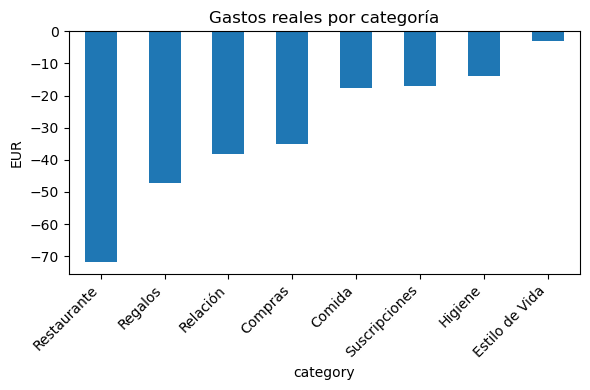

In [13]:
# Gastos por categoría
plt.figure(figsize=(6,4))
gastos_cat.plot(kind="bar")
plt.title("Gastos reales por categoría")
plt.ylabel("EUR")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

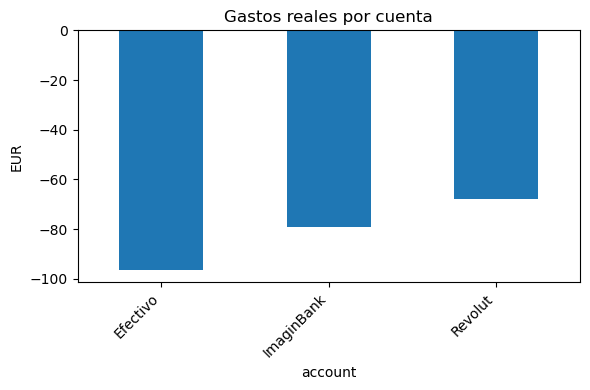

In [14]:
# Gastos por cuenta
plt.figure(figsize=(6,4))
gastos_por_cuenta.plot(kind="bar")
plt.title("Gastos reales por cuenta")
plt.ylabel("EUR")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

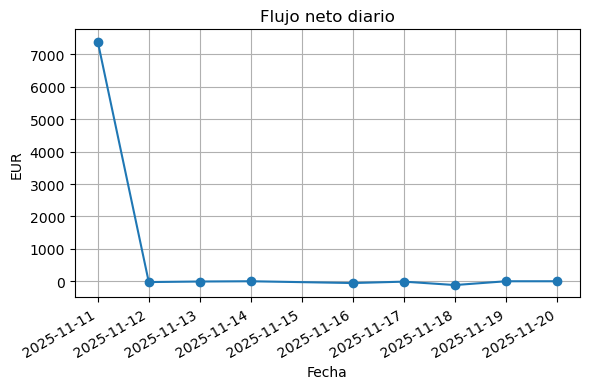

In [15]:
# Flujo diario neto
plt.figure(figsize=(6,4))
neto_diario.plot(marker="o")
plt.title("Flujo neto diario")
plt.xlabel("Fecha")
plt.ylabel("EUR")
plt.grid(True)
plt.tight_layout()
plt.show()